In [4]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from sklearn.metrics import classification_report
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
# -----------------------------
# Implementing Confusion Matrix
#------------------------------

def plot_confusion_matrix(all_labels, all_preds, classes):

    #Calculating the matrix
    cm = confusion_matrix(all_labels, all_preds)

    #Create the plot
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix: ', fontsize=15)
    plt.show()

In [6]:
# ------------------------------
# Dataset download
# ------------------------------
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

100%|██████████| 1.14G/1.14G [00:10<00:00, 117MB/s] 

Extracting files...


Device: cpu


In [7]:
# ---------------------
# Transforms
# ---------------------
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [8]:
# ---------------------------------
# Bsse dataset (no transfomations)
# ---------------------------------
base_dataset = datasets.ImageFolder(path)
classes = base_dataset.classes
num_classes = len(classes)
print(classes)
print(num_classes)

['original', 'standardized_256', 'standardized_384']
3


In [9]:
# -----------------------------
# Train / Val split (ONCE)
# -----------------------------
val_percent = 0.2
num_total = len(base_dataset)
num_val = int(num_total * val_percent)
num_train = num_total - num_val

generator = torch.Generator().manual_seed(42)

train_indices, val_indices = torch.utils.data.random_split(
    range(num_total),
    [num_train, num_val],
    generator=generator
)

In [10]:
# ----------------------------------
# Subsets with different transforms
# ----------------------------------
class TransformedSubset(torch.utils.data.Dataset):

    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, index):
        image, label = self.base_dataset[self.indices[index]]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.indices)
    
train_dataset = TransformedSubset(base_dataset, train_indices, train_transform)
val_dataset = TransformedSubset(base_dataset, val_indices, val_transform)

In [11]:
# --------------------
# DataLoaders
# --------------------
num_workers = os.cpu_count() // 2

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=num_workers
)

print(f"Classes: {classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation semples: {len(val_dataset)}")

Classes: ['original', 'standardized_256', 'standardized_384']
Train samples: 32036
Validation semples: 8008


In [12]:
# ----------------
# Model
# ----------------
model = models.mobilenet_v3_small(weights="DEFAULT")

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last feature block
for param in model.features[-1].parameters():
    param.requires_grad = True

#Replace classifier
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 256),
    nn.Hardswish(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 93.2MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [13]:
# -----------------
# Training setup
# -----------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

In [ ]:
# ---------------------
# Production-Grade Training Loop
# ---------------------
def train_model(model, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    # Using a more dynamic scheduler for production
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100 * (correct / total)

        # validation phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, v_preds = torch.max(outputs, 1) # fix: Use validation outputs, not training preds
                val_correct += (v_preds == labels).sum().item()
                val_total += labels.size(0)

                all_preds.append(v_preds.cpu())
                all_labels.append(labels.cpu())

        val_loss = val_running_loss / val_total
        val_acc = 100 * (val_correct / val_total)
        
        # Update scheduler
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        # --- early stopping and checkpointing ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_waste_model.pth")
            print(f"New best model saved with Val Loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Load the best weights before finishing
    model.load_state_dict(torch.load("best_waste_model.pth"))
    
    # Final Evaluation Report
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    #Confusion Matrix
    print('\nFinal Classification Report\n', '-'*30)
    print(classification_report(all_labels, all_preds, target_names=classes))
    plot_confusion_matrix(all_labels, all_preds, classes)

Epoch [1/10] Train Loss: 0.7238 Acc: 77.25% | Val Loss: 0.5462 Acc: 82.63%
New best model saved with Val Loss: 0.5462
Epoch [2/10] Train Loss: 0.5762 Acc: 81.57% | Val Loss: 0.4901 Acc: 84.12%
New best model saved with Val Loss: 0.4901
Epoch [3/10] Train Loss: 0.5270 Acc: 82.88% | Val Loss: 0.4670 Acc: 85.38%
New best model saved with Val Loss: 0.4670
Epoch [4/10] Train Loss: 0.4947 Acc: 83.94% | Val Loss: 0.4450 Acc: 85.60%
New best model saved with Val Loss: 0.4450
Epoch [5/10] Train Loss: 0.4625 Acc: 85.06% | Val Loss: 0.4333 Acc: 86.10%
New best model saved with Val Loss: 0.4333
Epoch [6/10] Train Loss: 0.4437 Acc: 85.41% | Val Loss: 0.4117 Acc: 87.04%
New best model saved with Val Loss: 0.4117
Epoch [7/10] Train Loss: 0.4261 Acc: 86.20% | Val Loss: 0.4074 Acc: 87.18%
New best model saved with Val Loss: 0.4074
Epoch [8/10] Train Loss: 0.4072 Acc: 86.75% | Val Loss: 0.3886 Acc: 87.33%
New best model saved with Val Loss: 0.3886
Epoch [9/10] Train Loss: 0.4031 Acc: 87.10% | Val Loss: 

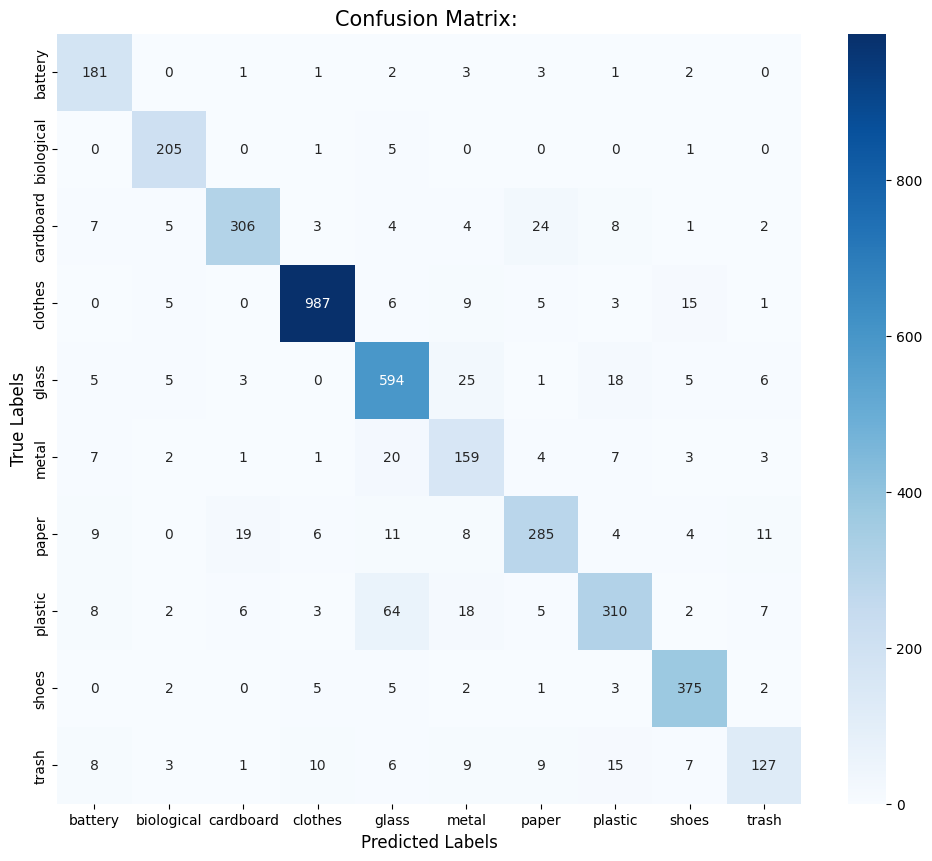

In [50]:
train_model(model, num_epochs=10, patience=5)
torch.save(model.state_dict(), "mobilenetv3_waste.pth")

In [14]:
torch.save(model.state_dict(), "mobilenetv3_waste.pth")